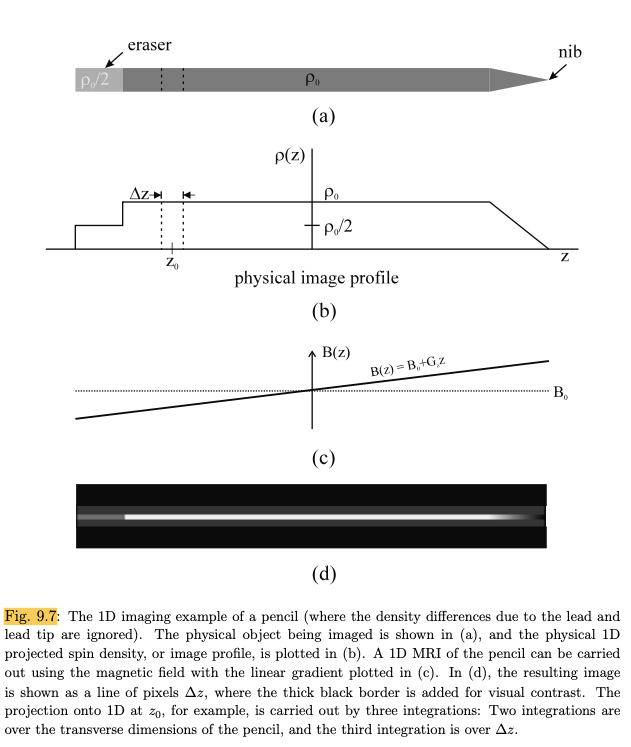

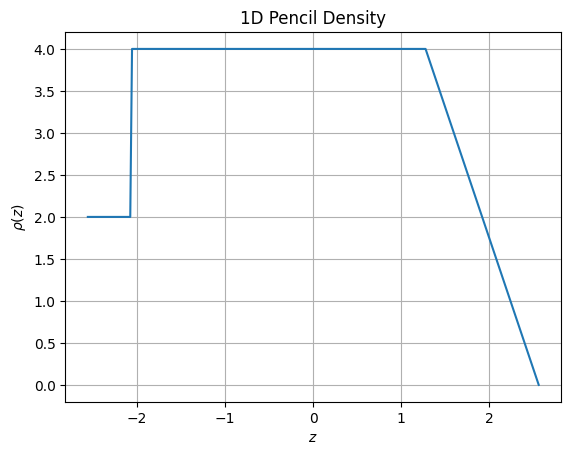

Text(0, 0.5, 'y-axis magnetization')

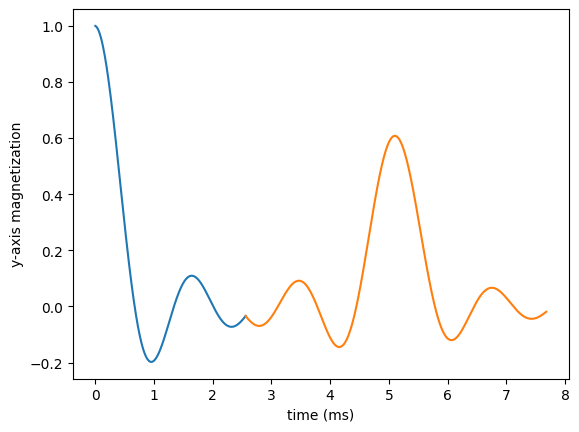

In [1]:
from utilities import *
import matplotlib.pyplot as plt

# Object settings

z = 2.56 # mm 
delta_z = 0.02 # 256 points

rho_0 = 4
pencil_density_profile = density_pencil(z=z, delta_z=delta_z, rho_0=rho_0, plot=True)

# properties settings
T1  = 15*2 # ms. magnetization relaxation time in longitudinal direction
T2  = 10.24 # ms. magnetization relaxation time in transverse direction
# T2s = 0 # ms T2 star
# TE = 1e-2 # ms
TS = 5.12 # ms

B_0 = 0
G_x = 4.6e-3
gamma_bar = 400
gamma = gamma_bar * 2 * np.pi
w0 = B_0 * gamma_bar

# environment settings

# Time
# 0 -- t1 -- t2 -- t3 -- t4
# t1 = 6e-3 # ms set to be 0
# t2 = t1 + TS / 2 # ms
delta_t = 1e-2 # ms
num_of_time = int(TS / delta_t) # between t3 and t4

# ADC sampling setting
delta_k = 1 / 5.12 # /mm^-1
# delta_k = gamma_bar * G_x * delta_t * 1 # 1/delta_k bigger than 5.12
# delta_k = 0.1 # mm^-1, 1/delta_x bigger than 5.12 
FOV = 1 / delta_k # mm

# gradient pulse sequence
# z is just consistent with the physical image profile, not z-axis
pos_z = np.linspace(-z, z-delta_z, int((z / delta_z) * 2))
num_of_points = len(pos_z) # also the number of spins, number of samples on k and x space

# get the m0 depend on the density profile
m0 = pencil_density_profile

# create spins after the rf pulse (lying on the y-axis)
vec_spins = np.zeros((3, num_of_points))
vec_spins[1, :] = 1

# G_x on between t1 and t2 (T_s / 2)
w_G = w_grad(w_0=w0, G_value=G_x, gamma=gamma_bar, pos=pos_z, dim=1)
res_1 = multiple_FID(vec_spins, m0, w0, w_G, T1, T2, TS / 2, int(num_of_time / 2), 'z')

res_mean = np.mean(res_1, axis=-1)
time1 = res_mean.shape[1]
plt.plot(np.linspace(0, time1*delta_t, time1), res_mean[1,:])
plt.xlabel('time (ms)')
plt.ylabel('y-axis magnetization')


# -G_x on between t2 and t3 (T_s)
w_G = w_grad(w_0=w0, G_value=-G_x, gamma=gamma_bar, pos=pos_z, dim=1)
res_2 = multiple_FID(res_1[:,-1,:], m0, w0, w_G, T1, T2, TS, num_of_time, 'z')

res_mean = np.mean(res_2, axis=-1)
time2 = res_mean.shape[1]
plt.plot(delta_t * time1 + np.linspace(0, time2*delta_t, time2), res_mean[1,:])
plt.xlabel('time (ms)')
plt.ylabel('y-axis magnetization')


Text(0.5, 1.0, '512 points')

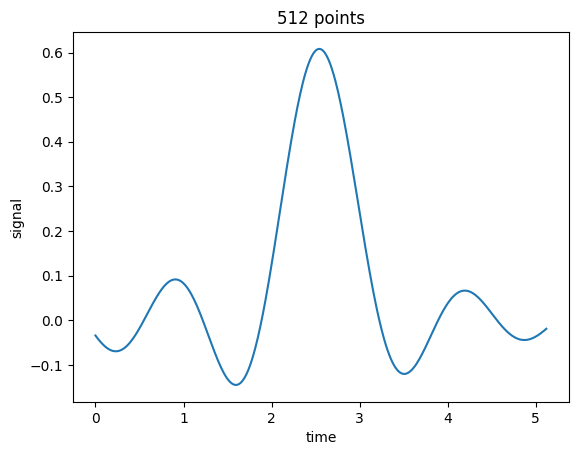

In [2]:
#extract s(t) during ADC process
s_t = res_mean[1,:]
plt.plot(np.linspace(0, time2*delta_t, time2), s_t)
plt.xlabel('time')
plt.ylabel('signal')
plt.title('512 points')

### 1. finite sampling (reduce the domain of the k-space)

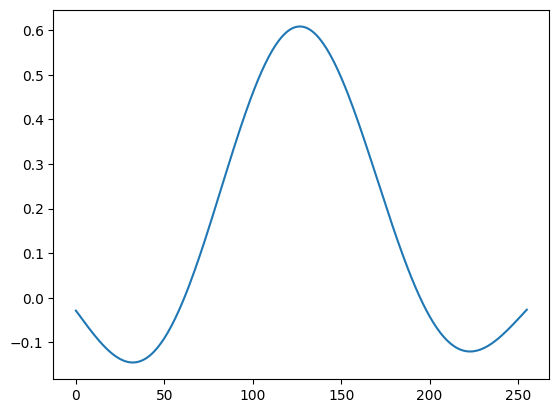

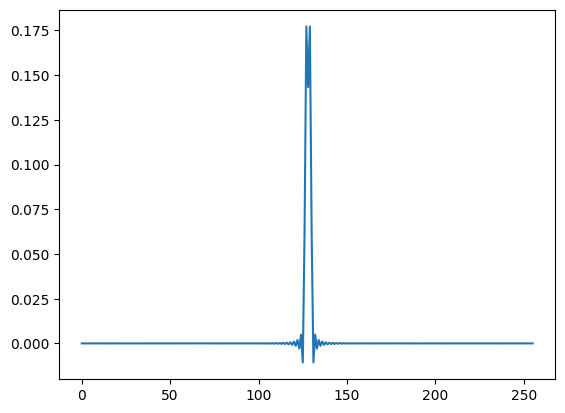

In [3]:
s_mk_1 = s_t[127:383]
plt.plot(s_mk_1)
plt.show()
rho_m_x_1 = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(s_mk_1)))
plt.plot(np.real(rho_m_x_1))

## 2. another sampling function

Text(0.5, 1.0, '256 points sampled and truncated signal')

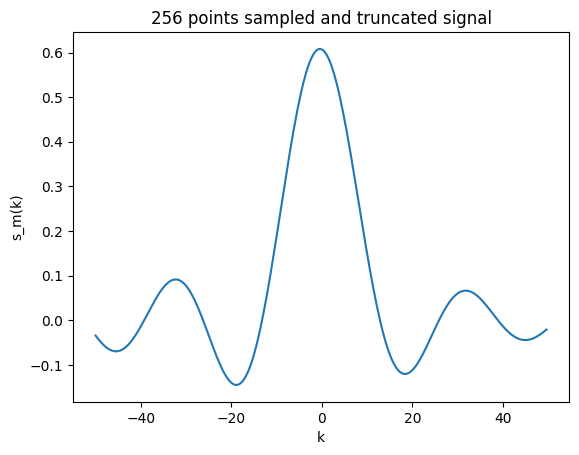

In [4]:
# num_steps != num_of_points. apply sampling function
# ! num_of_points = num_steps always

s_mk = s_t
x_axis = np.linspace(start=-z, stop=z-delta_z, num=num_of_points)
k_axis = np.linspace(start=-num_of_time / 2 * delta_k, stop= (num_of_time / 2 - 1) * delta_k, num=num_of_time)

s_mk_sampled = s_mk[::2]
k_axis_sampled = k_axis[::2]
plt.plot(k_axis_sampled, s_mk_sampled)

plt.xlabel('k')
plt.ylabel('s_m(k)')
plt.title('256 points sampled and truncated signal')

Text(0, 0.5, 'rho')

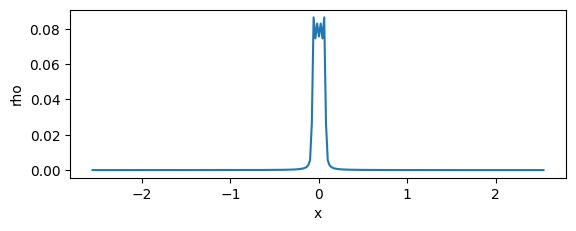

In [5]:
# Compute the inverse Fourier transform
rho_m_x = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(s_mk_sampled)))
plt.subplot(2, 1, 1)
plt.plot(x_axis, np.abs(rho_m_x))
plt.xlabel('x')
plt.ylabel('rho')

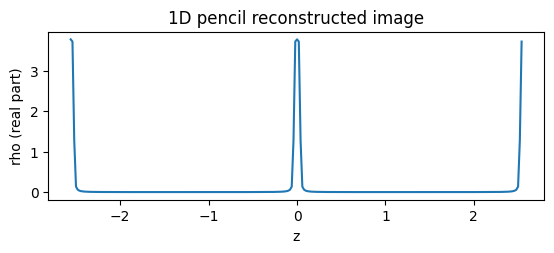

In [6]:
# By equation 12.21
rho = []
for xi in x_axis:
    rho.append(delta_k * np.sum(s_mk_sampled * np.exp(1j * 2 * np.pi * k_axis_sampled * xi)))

rho = np.array(rho)
plt.subplot(2, 1, 1)
plt.plot(x_axis,np.real(rho))
plt.xlabel('z')
plt.ylabel('rho (real part)')
plt.title('1D pencil reconstructed image')
plt.show()


## FT of the density profile

Text(0, 0.5, 'k')

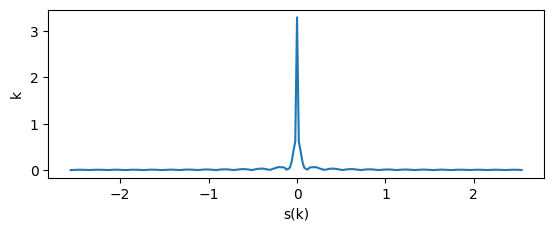

In [7]:
rho = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(pencil_density_profile)))
plt.subplot(2, 1, 1)
plt.plot(x_axis, np.abs(rho))
plt.xlabel('s(k)')
plt.ylabel('k')

Text(0, 0.5, 'rho')

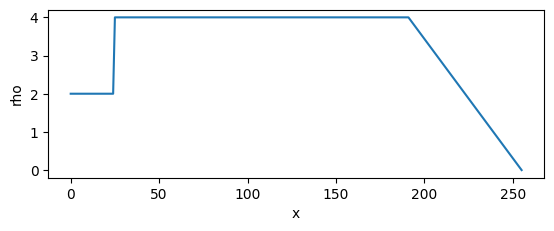

In [8]:
rho_m_x = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(rho)))
plt.subplot(2, 1, 1)
plt.plot(np.abs(rho_m_x))
plt.xlabel('x')
plt.ylabel('rho')